# week 5
## goals:
- use the API code or the downloaded borders
- input the actual boundaries of the MPAs
- for now: ignore when MPAs were implemented, and:
    - group by WDPAID
    - produce list of WDPAIDs by how much effort was contained 2012-2016 (the existing data set)

TODO:
- convert points to a geopandas dataframe including the geoseries column (these are points? boxes?)


## notes/learnings:
- just download 3GiB protected areas from protected planet!
- use geopandas to make a GeoDataFrame, the polygons are then a GeoSeries and we can ask .contains() or crosses() with the points (or boxes) of fishing effort
- only 5699 unique WDPAIDs
- need to construct southern latitude, western longitude, 100th degree box


### largest MPAs:
1. Marae Moana (Cook Islands) WDPAID = 555624907
2. Ross Sea Region (Ross Sea)
3. Papahanaumokuakea Marine National Monument (PMNM) [177, -160], [19, 32] 220201
4. Natural Park of the Coral Sea
5. Pacific Remote Islands (expanded) 400011
6. Coral Sea Marine Park
7. French Southern Territories Marine Reserve
8. Phoenix Islands wdpaid: 309888
9. Stellar Sea Lion Protection Areas (just Aleutian Islands 2015)


In [1]:
import numpy as np
import pandas
from datetime import datetime
import matplotlib.pyplot as plt
import os
import pywdpa
import geopandas
import contextily as ctx
from shapely import geometry
import pretty_html_table

pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', 20)

In [2]:
# reads the downloaded WPDA polygon files
protected_areas = pandas.concat([
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp0/WDPA_WDOECM_wdpa_shp-polygons.shp"),
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp1/WDPA_WDOECM_wdpa_shp-polygons.shp"),
    geopandas.read_file("data/WDPA_WDOECM_wdpa_shp/WDPA_WDOECM_wdpa_shp2/WDPA_WDOECM_wdpa_shp-polygons.shp")
])
# filters for marine only (may want to change this to 1 or 2 (2 is marine only, 1 is mixed, 0 is terrestrial))
mpas = protected_areas[protected_areas["MARINE"] == "2"]
# delete the larger table - it's like 3 GiB and not needed past this point
del(protected_areas)

<AxesSubplot:>

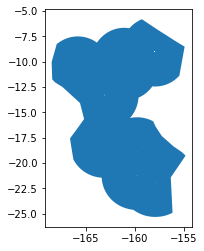

In [3]:
# Marae Moana:
mpas[mpas["WDPAID"] == 555624907.0].plot()

<AxesSubplot:>

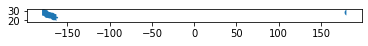

In [4]:
# PMNM
mpas[mpas["WDPAID"] == 220201.0].plot()

In [5]:
# How many unique WDPAIDs are there in the whole set of MPAs?
mpas["WDPAID"].nunique()

5699

In [6]:
mpas.sort_values("REP_M_AREA", ascending=False)

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,MARINE,REP_M_AREA,GIS_M_AREA,REP_AREA,GIS_AREA,NO_TAKE,NO_TK_AREA,STATUS,STATUS_YR,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
32494,555624907.0,555624907_A,1,Marae Moana (Cook Islands Marine Park),Marae Moana,Marine Park,Marine Park,National,VI,Not Applicable,2,1.968938e+06,1.981965e+06,1.968938e+06,1.982029e+06,None,0.000000,Designated,2017,Collaborative governance,State,Marae Moana Council,Not Reported,State Verified,1986,Not Reported,COK,COK,Not Applicable,Not Applicable,"POLYGON ((-158.12784 -15.86933, -157.86861 -16..."
56326,220201.0,220201,1,Papahanaumokuakea Marine National Monument,Papahanaumokuakea Marine National Monument,Marine Protected Area,Marine Protected Area,National,Ib,Not Applicable,2,1.508847e+06,1.508798e+06,1.508847e+06,1.508817e+06,Not Reported,0.000000,Designated,2006,Collaborative governance,Multiple ownership,U.S. Fish & Wildlife Service / State Departmen...,Not Reported,State Verified,1848,US-UNKF / US-HI,USA,USA,Not Applicable,Not Applicable,"MULTIPOLYGON (((-172.18795 29.11750, -172.1827..."
7815,555577562.0,555577562,1,Natural Park of the Coral Sea,Parc Naturel de la Mer de Corail,Parc Naturel,Natural Park,National,VI,Not Applicable,2,1.292962e+06,1.294950e+06,1.292967e+06,1.291643e+06,Part,3236.000000,Designated,2014,Sub-national ministry or agency,Not Reported,New Caledonian Government,http://www.affmar.gouv.nc/portal/page/portal/a...,State Verified,1834,Not Reported,FRA,NCL,Not Applicable,Not Applicable,"POLYGON ((164.16940 -15.91227, 164.36711 -16.1..."
65899,555547601.0,555547601,1,South Georgia and South Sandwich Islands Marin...,South Georgia and South Sandwich Islands Marin...,Marine Protected Area,Marine Protected Area,National,VI,Not Applicable,2,1.240000e+06,1.065900e+06,1.240000e+06,1.069872e+06,Part,302846.595194,Designated,2012,Federal or national ministry or agency,Not Reported,Government of South Georgia and South Sandwich...,http://www.sgisland.gs/download/MPA/MPA%20Plan...,State Verified,1679,Not Reported,GBR,SGS,Not Applicable,Not Applicable,"MULTIPOLYGON (((-36.19410 -54.46968, -36.19298..."
31780,555624172.0,555624172,1,Pitcairn Islands Marine Reserve,Pitcairn Islands Marine Reserve,Marine Reserve,Marine Reserve,National,Not Reported,Not Applicable,2,8.343340e+05,8.395683e+05,8.343340e+05,8.395683e+05,Part,832017.000000,Designated,2016,Not Reported,State,United Kingdom,In progress – completion 2017,State Verified,1896,Not Reported,GBR,PCN,Not Applicable,Not Applicable,"MULTIPOLYGON (((-124.79214 -24.67753, -124.792..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57105,302289.0,302289,1,Arrecifes de la Cordillera Natural Reserve,Arrecifes de la Cordillera Natural Reserve,Marine Protected Area,Marine Protected Area,National,IV,Not Applicable,2,0.000000e+00,9.826429e+01,1.008255e+02,1.008255e+02,Not Reported,0.000000,Designated,1980,Sub-national ministry or agency,State,State Fish and Wildlife,Not Reported,State Verified,1848,US-PR,USA,PRI,Not Applicable,Not Applicable,"POLYGON ((-65.41544 18.35222, -65.41627 18.331..."
56994,301880.0,301880,1,Talang-Satang National Park,Talang-Satang National Park,National Park,National Park,National,II,Not Applicable,2,0.000000e+00,1.019663e+02,1.026090e+02,1.032919e+02,Not Reported,0.000000,Designated,1999,Not Reported,Not Reported,Sarawak Forestry Corporation (SFC),Not Reported,State Verified,1998,Not Reported,MYS,MYS,Not Applicable,Not Applicable,"POLYGON ((110.13099 1.81674, 110.14384 1.82459..."
56370,300049.0,300049,1,Isla Leones,Isla Leones,Área de Uso Limitado Bajo Protección Especial,Limited Use Area Under Special Protection,National,VI,Not Applicable,2,0.000000e+00,1.172460e+01,1.150000e+01,1.172460e+01,Not Reported,0.000000,Designated,1991,Sub-national ministry or agency,Not Reported,Not Reported,Not Repo

In [7]:
## Load the fishing hours data (this is kinda slow)
filenames = os.listdir('data/daily_csvs')

# this might be faster but the status printout is nice:
# points = pandas.concat([geopandas.read_file('data/daily_csvs/' + filename) for filename in filenames])

counted = 0
points = []
for filename in filenames:
    print(f'\r {filename} {counted}/{len(filenames)}', end='')
    points.append(pandas.read_csv('data/daily_csvs/' + filename,
                                      dtype={'lat_bin': 'int16',
                                             'lon_bin': 'int16',
                                             'mmsi': 'int32',
                                             'fishing_hours': 'float32'},
                                 parse_dates=['date']))
    counted += 1
points = pandas.concat(points) # deliberately overwriting points

 2013-12-20.csv 1826/1827

In [ ]:
points.info()

In [8]:
def compute_box(row, width=0.1):
    x = float(row['lon_bin'] * width)
    y = float(row['lat_bin'] * width)
    return geometry.box(x, y, x+width, y+width)

## Aggregate the points and bin them
points_aggregate = points.groupby(['lat_bin', 'lon_bin']).aggregate({'lat_bin': 'first', 'lon_bin': 'first', 'fishing_hours': 'sum'})
points_aggregate['geometry'] = points_aggregate.apply(compute_box, axis=1)
geopoints = geopandas.GeoDataFrame(points_aggregate, geometry=points_aggregate['geometry']).set_crs(epsg=4326)


points[['lat_bin_1d', 'lon_bin_1d']] = points[['lat_bin', 'lon_bin']].applymap(lambda x : int(round(x / 10)))
points_aggregate_1d = points.groupby(['lat_bin_1d', 'lon_bin_1d']).aggregate({'lat_bin_1d': 'first', 'lon_bin_1d': 'first', 'fishing_hours': 'sum'})
points_aggregate_1d.rename({'lat_bin_1d': 'lat_bin', 'lon_bin_1d': 'lon_bin'})



points_aggregate_1d['geometry'] = points_aggregate.apply(
    lambda x : compute_box(x, width=1), axis=1)

geopoints_1d = geopandas.GeoDataFrame(points_aggregate_1d, geometry=points_aggregate_1d['geometry']).set_crs(epsg=4326)

KeyboardInterrupt: 

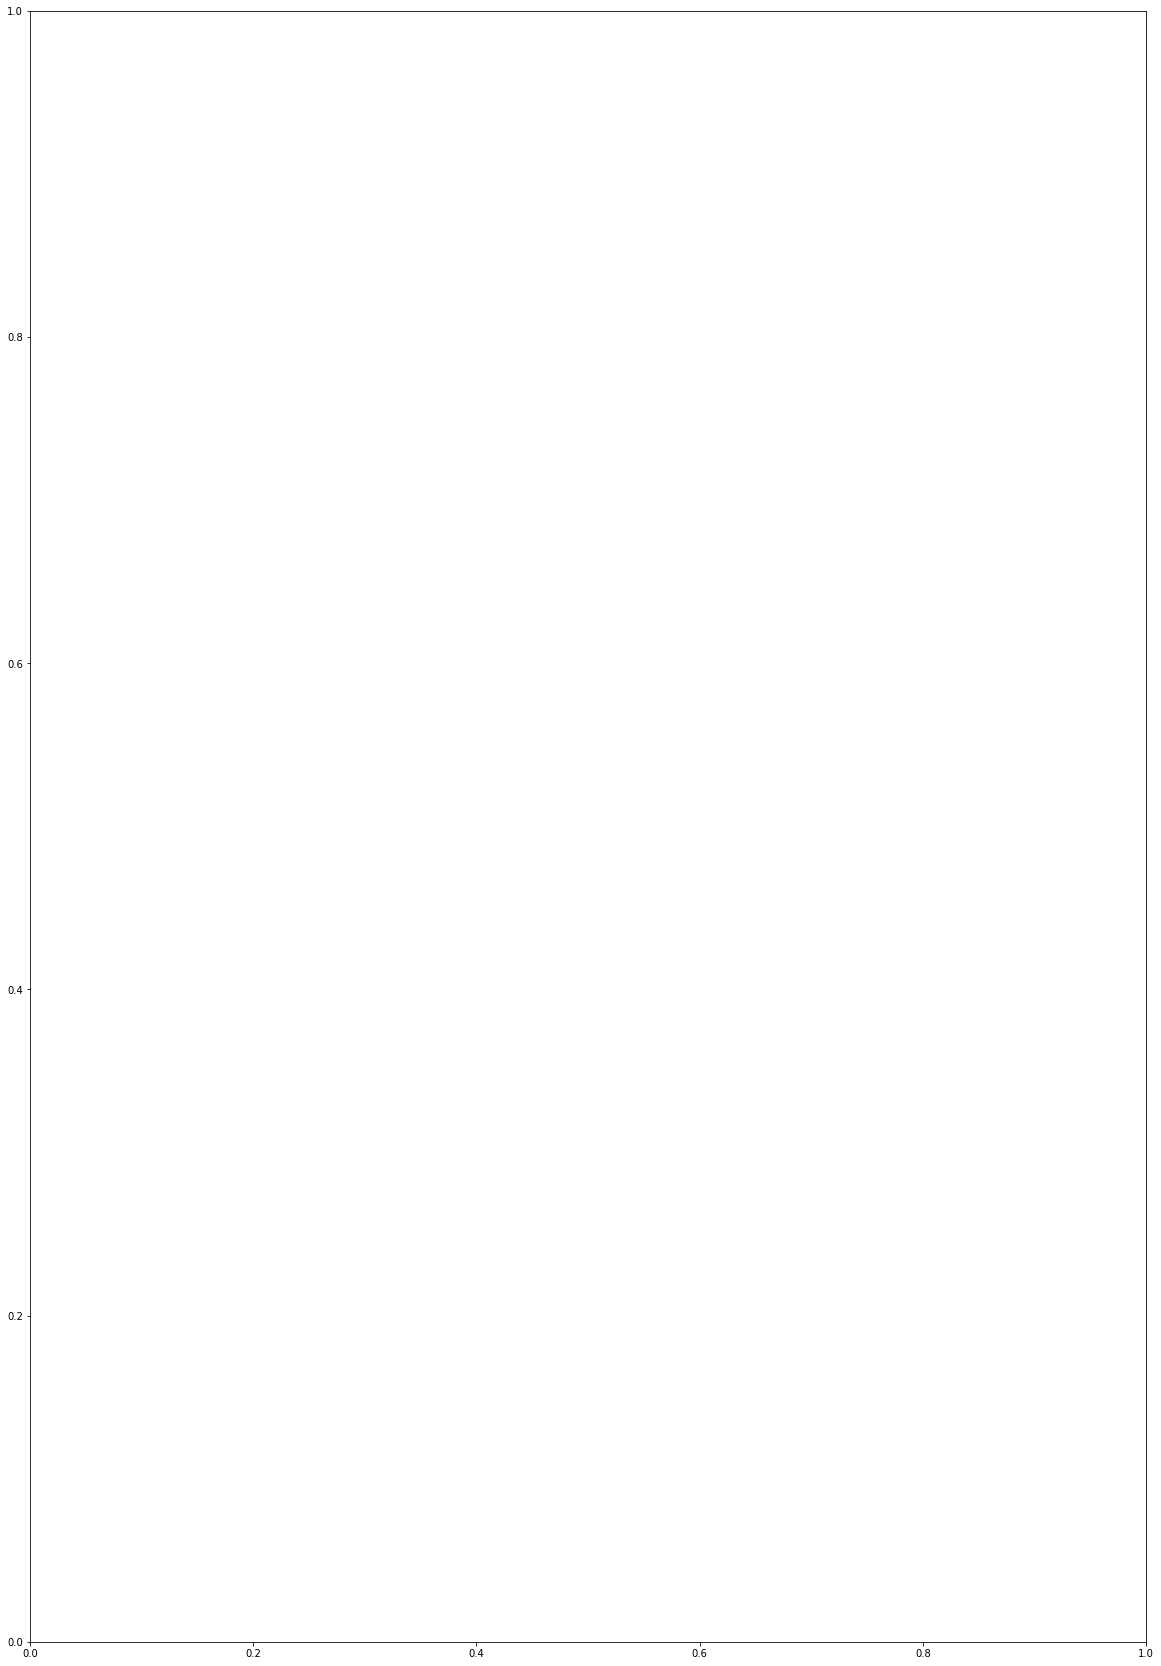

In [9]:
## Plot it all!
ax = geopoints.plot(column='fishing_hours', figsize=(20, 30), markersize=1, cmap='Blues', scheme='quantiles', legend=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black', ax=ax, )



marae = mpas[mpas["WDPAID"] == 555624907.0]
pmnm = mpas[mpas["WDPAID"] == 220201.0]

LINEWIDTH = 0.5
mpas.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH)

plt.title('fishing hours 2012-2016 in 0.1 degree aggregate')


In [ ]:
## Plot it all!
ax = geopoints_1d.plot(column='fishing_hours', figsize=(20, 30), markersize=1, cmap='Blues', scheme='quantiles', legend=True)

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='white', edgecolor='black', ax=ax, )



marae = mpas[mpas["WDPAID"] == 555624907.0]
pmnm = mpas[mpas["WDPAID"] == 220201.0]

LINEWIDTH = 0.5
#marae.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH)
#pmnm.plot(ax=ax, color='None', edgecolor='red')
mpas.plot(ax=ax, color='None', edgecolor='red', linewidth=LINEWIDTH)

plt.title('fishing hours 2012-2016 in 1 degree aggregate')

In [10]:
# Produce ranked list of mpas by amount of effort inside their borders
# q - should we join by id or something first?

mpas_ = mpas[['WDPAID', 'NAME', 'geometry', 'STATUS_YR', 'REP_M_AREA', 'REP_AREA', 'NO_TAKE']]
joined_points = geopandas.sjoin(geopoints, mpas_, op='within')


In [11]:
def string_join(strings):
    base = strings.iloc[0] if strings.any() else ''
    for s in strings[1:]:
        base = base if s in base else base + '|' + s
    return base


joined_points_aggregate = joined_points.groupby(['WDPAID'], as_index=False).aggregate({
    'NAME': string_join,
    'fishing_hours': 'sum',
    'STATUS_YR': 'first',
    'REP_M_AREA': 'sum',
    'REP_AREA': 'sum',
    'NO_TAKE': string_join,
})



In [12]:
sorted_mpas = joined_points_aggregate.sort_values("fishing_hours", ascending=False)

In [13]:
sorted_mpas

,WDPAID,NAME,fishing_hours,STATUS_YR,REP_M_AREA,REP_AREA,NO_TAKE
620,555643633.0,Mers Celtiques - Talus du golfe de Gascogne,645055.500000,2018,0.000000e+00,5.166802e+07,Not Reported
587,555635560.0,Mers Celtiques - Talus du golfe de Gascogne,625829.125000,0,0.000000e+00,3.776594e+07,Not Reported
64,365015.0,Pelagos Sanctuary For The Conservation Of Mari...,459718.875000,2001,4.112500e+07,4.112500e+07,Not Reported
32,178830.0,Santuario Per I Mammiferi Marini,311001.718750,1999,0.000000e+00,3.068710e+06,Not Reported
88,478638.0,The Wadden Sea,245386.531250,2009,0.000000e+00,4.344931e+05,Not Reported
...,...,...,...,...,...,...,...
92,900736.0,Elizabeth and Middleton Reefs Marine National ...,0.495556,2002,1.877262e+03,1.877262e+03,Not Reported
220,555539549.0,Iles d'Hyères,0.462083,2018,0.000000e+00,4.790500e+02,Not Reported
155,555526860.0,Rade d'Hyères,0.462083,2011,0.000000e+00,4.886700e+02,Not Reported
80,478044.0,East Chatham Rise,0.351250,2007,5.369049e+03,5.369049e+03,Part


In [14]:
since_2016 = sorted_mpas[sorted_mpas['STATUS_YR'] >= 2016]
since_2014 = sorted_mpas[sorted_mpas['STATUS_YR'] >= 2014]


reprint = True
if reprint:
    f = open("2016_or_later_box.html", "w")
    f.write(pretty_html_table.build_table(since_2016, 'blue_light'))
    f.close()

    f = open("2014_or_later_box.html", "w")
    f.write(pretty_html_table.build_table(since_2014, 'blue_light'))
    f.close()

    f = open("all_mpas_by_fishing_hours_box.html", "w")
    f.write(pretty_html_table.build_table(sorted_mpas, 'blue_light'))
    f.close()